In [1]:
import tensorflow as tf

(train_images, train_labels), (test_images,
                               test_labels) = tf.keras.datasets.cifar10.load_data()

class_names = ['airplane', 'automobile', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images.astype(
    'float32') / 255.0, test_images.astype('float32') / 255.0

In [2]:
import pickle

model = tf.keras.models.Sequential()

# Input layer
model.add(tf.keras.layers.Conv2D(128, kernel_size=(
    4, 4), padding='same', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.LeakyReLU())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.LeakyReLU())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.LeakyReLU())
model.add(tf.keras.layers.Conv2D(16, kernel_size=(2, 2), padding='same'))
model.add(tf.keras.layers.LeakyReLU())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.LeakyReLU())
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.LeakyReLU())
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.LeakyReLU())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# epochs = 100
# batch_size = 256
# history = model.fit(train_images, train_labels, epochs=epochs, callbacks=tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', patience=5, verbose=2), validation_data=(test_images, test_labels))


with open('history.pkl', 'rb') as file:
    history = pickle.load(file)

model.load_weights('weights.keras')
loss, accuracy = model.evaluate(test_images, test_labels)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

313/313 [==============================] - 6s 18ms/step - loss: 0.7166 - accuracy: 0.7550
Test Loss: 0.7165738940238953
Test Accuracy: 0.7549999952316284


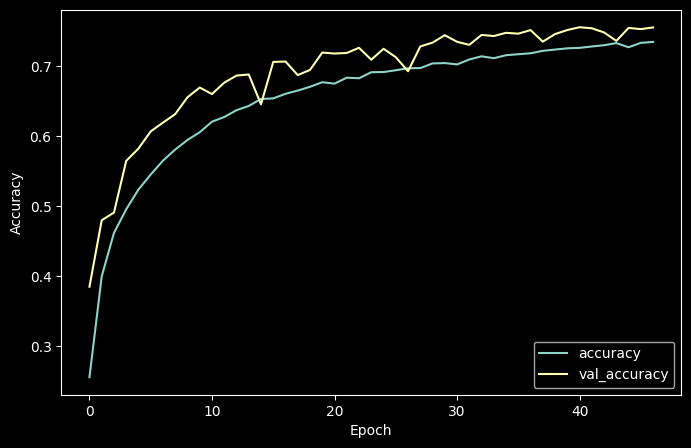

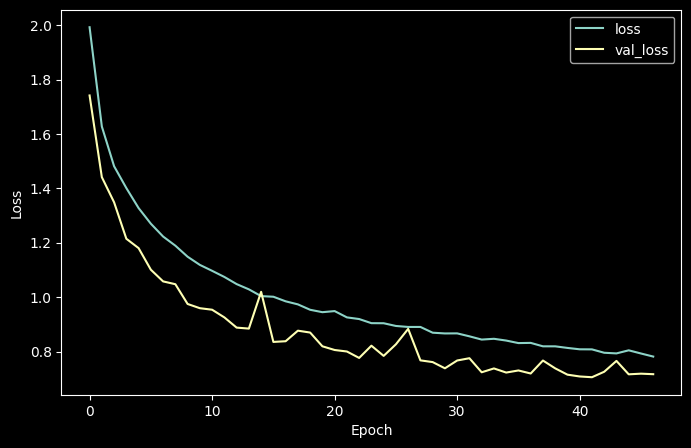

In [3]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from itertools import cycle
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.figure(figsize=(8, 5))
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


def roc_plot(y_test, y_prob):

    y_test = label_binarize(y_test, classes=range(10))

    n_classes = y_test.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['blue', 'green', 'red', 'magenta', 'yellow',
                   'brown', 'orange', 'darkgreen', 'gold'])

    plt.figure(figsize=(8, 5))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristics')
    plt.legend(loc="lower right")
    plt.show()


def cm_plot(conf_matrix, labels):

    plt.figure(figsize=(8, 5))
    sns.heatmap(conf_matrix, cmap='Blues', annot=True, fmt='d',
                xticklabels=labels, yticklabels=labels)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

313/313 - 5s - 5s/epoch - 16ms/step


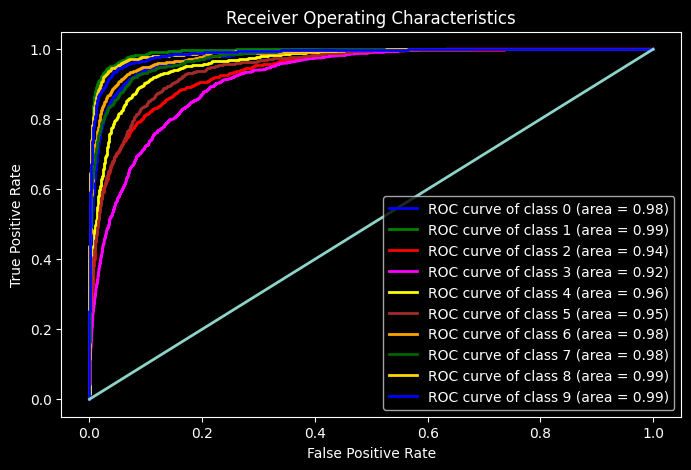

0.7277777777777779
              precision    recall  f1-score   support

           0       0.73      0.82      0.77      1000
           1       0.87      0.89      0.88      1000
           2       0.62      0.66      0.64      1000
           3       0.61      0.50      0.55      1000
           4       0.71      0.70      0.70      1000
           5       0.70      0.62      0.66      1000
           6       0.85      0.79      0.82      1000
           7       0.78      0.80      0.79      1000
           8       0.83      0.90      0.86      1000
           9       0.81      0.89      0.85      1000

    accuracy                           0.76     10000
   macro avg       0.75      0.76      0.75     10000
weighted avg       0.75      0.76      0.75     10000



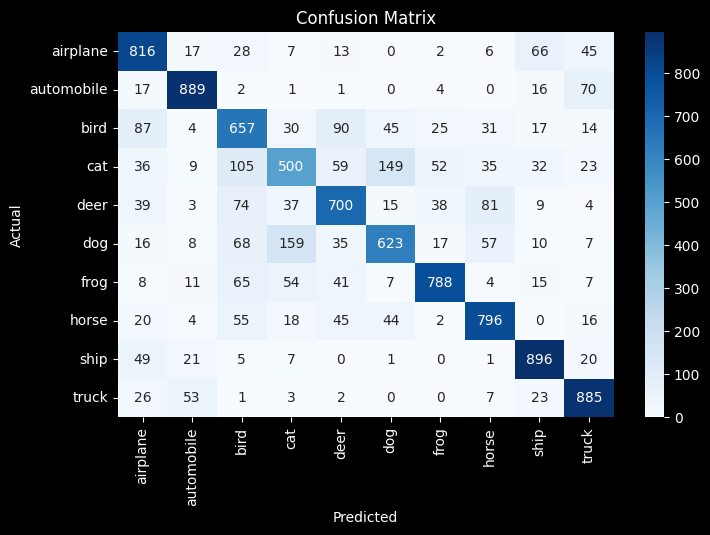

In [4]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import numpy as np

y_prob = model.predict(test_images, verbose=2)
y_pred = np.argmax(y_prob, axis=1)

roc_plot(test_labels, y_prob)
print(cohen_kappa_score(test_labels.squeeze(), y_pred))
print(classification_report(test_labels, y_pred))
cm_plot(confusion_matrix(test_labels, y_pred), class_names)